In [1]:
import numpy as np
from pathlib import Path as _Path
from torchsummary import summary
import torch

%load_ext autoreload
%autoreload 2
import seisbench
import seisbench.data as sbd
import seisbench.models as sbm
import matplotlib.pyplot as plt
import copy
from utils import Solver, ProbabilisticLabeller
from blocks import *
import logging

seisbench.cache_root = _Path("../")
seisbench.cache_data_root = _Path("../datasets/")
seisbench.cache_model_root = seisbench.cache_root / 'models' / 'v3'
# seisbench.remote_model_root = 'https://dcache-demo.desy.de:2443/Helmholtz/HelmholtzAI/SeisBench/models/v3/'
# seisbench.config = {'dimension_order': 'NCW', 'component_order': 'ZNE'}
# seisbench.__version__ = '0.5.2'

# logger = logging.getLogger('seisbench')
# logger.setLevel(logging.INFO)
# seisbench.logger = logger


In [2]:
data = sbd.Iquique(sampling_rate=100)
df_meta = data.metadata
mask = (~df_meta['trace_P_arrival_sample'].isna() &
        ~df_meta['trace_S_arrival_sample'].isna())

data.filter(mask)
train, dev, test = data.train_dev_test()


2023-10-04 15:34:31,048 | seisbench | WARNING | Check available storage and memory before downloading and general use of Iquique dataset. Dataset size: waveforms.hdf5 ~5Gb, metadata.csv ~2.6Mb


737


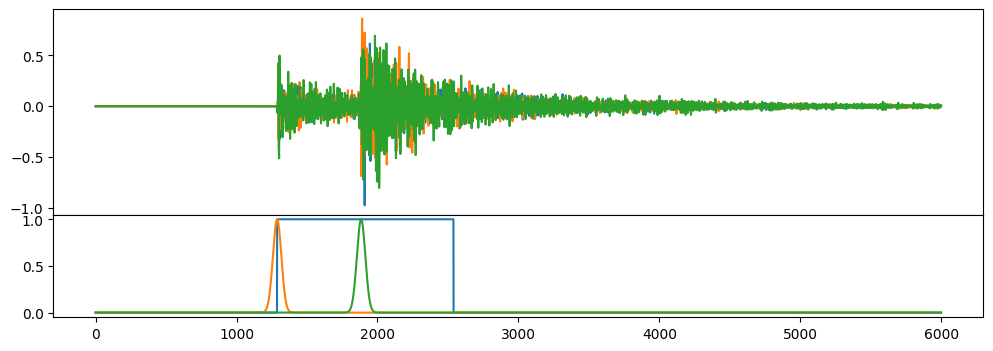

In [3]:
import seisbench.generate as sbg
import matplotlib.pyplot as plt

phase_dict = {
    "trace_P_arrival_sample": "P",
    "trace_S_arrival_sample": "S"
}

train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)

sigma = 30
augmentations = [
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=2000, windowlen=8000, selection="first", strategy="pad"),
    sbg.RandomWindow(windowlen=6000, strategy="move"),
    sbg.Normalize(demean_axis=-1, detrend_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.Filter(btype='bandpass', Wn=[2, 25], N=6),
    sbg.ChangeDtype(np.float32),
    # sbg.GaussianNoise(scale=(0, 0.15)),
    ProbabilisticLabeller(label_columns=phase_dict, sigma=sigma, dim=0, use_detection=True, spectrogram_based=True)
]


train_generator.add_augmentations(augmentations)
dev_generator.add_augmentations(augmentations)

n = np.random.randint(len(train_generator))
# n = 4667
print(n)
sample = train_generator[n]

fig = plt.figure(figsize=(12, 4))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [2, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)
plt.show()

In [4]:
pt_data = "iquique"
eqt_model_path = seisbench.cache_root / 'models' / 'v3' / 'eqtransformer'

weights = torch.load(eqt_model_path / f'{pt_data}.pt.v2')
model_pt = sbm.EQTransformer(norm='std')
model_base = copy.deepcopy(model_pt)

model_pt.load_state_dict(weights)
model_eqt = copy.deepcopy(model_pt)
model_leq = copy.deepcopy(model_pt)

# replace encoder and decoder using separable conv1d
model_eqt.encoder = model_base.encoder
model_leq.encoder = EncoderSepConv1d(
            input_channels=model_pt.in_channels,
            filters=model_pt.filters,
            kernel_sizes=model_pt.kernel_sizes,
            in_samples=model_pt.in_samples
)

decoder = DecoderSepConv1d(
    input_channels=16,
    filters=model_pt.filters[::-1],
    kernel_sizes=model_pt.kernel_sizes[::-1],
    out_samples=model_pt.in_samples,
)

model_eqt.decoder_d = model_base.decoder_d 
model_leq.decoder_d = decoder
pick_decoders = [decoder for _ in range(2)]
model_eqt.pick_decoders = nn.ModuleList(pick_decoders)
model_leq.pick_decoders = nn.ModuleList(pick_decoders)

# replace res cnn stack to deeper bottleneck
model_eqt.res_cnn_stack = model_base.res_cnn_stack
model_leq.res_cnn_stack = DeeperBottleneckStack(
  kernel_sizes=model_pt.res_cnn_kernels,
  filters=model_pt.filters[-1],
  drop_rate=model_pt.drop_rate,
)

# replace single head to multi head transformer
Transformer = MultiHeadTransformerPreLN
num_heads = 4

model_eqt.transformer_d0 = model_base.transformer_d0
model_leq.transformer_d0 = Transformer(
  input_size=16, drop_rate=model_pt.drop_rate, num_heads=num_heads, eps=1e-5
)

model_eqt.transformer_d = model_base.transformer_d
model_leq.transformer_d = Transformer(
  input_size=16, drop_rate=model_pt.drop_rate, num_heads=num_heads, eps=1e-5
)

# pick_attentios = [nn.MultiheadAttention(embed_dim=16, num_heads=num_heads) for _ in range(2)]
# model_eqt.pick_attentions = model_base.pick_attentions
# model_leq.pick_attentions = nn.ModuleList(pick_attentios)

for model in [model_leq, model_eqt]:
  for name, param in model.named_parameters():
    if 'lstm' in name:
      param.requires_grad = False

for bs in [32]:
  print('batch size:', bs)
  config = dict(
    main = dict(batch_size=bs, folder_name=f'{pt_data}/LEQNet+_bs{bs}_sigma{sigma}'),
    train = dict (
      model= model_leq.to('cuda'), 
      learning_rate=1e-3,
      epochs=50,
      class_weights=[.03, .40, .58],
      print_every_batch=30,
      patience=12,
      adaptive_lr=True,
    )
  )

  solver = Solver(train_generator, dev_generator, **config['main'])
  solver.train(**config['train'])

batch size: 32

Epoch 1, Learning Rate: 0.001
-------------------------------
[   32/ 6718] loss: 0.608924 | loss_d: 0.690500 | loss_p: 0.570493 | loss_s: 0.620711 | f1_d: 0.000000 | f1_p: 0.042095 | f1_s: 0.042095
[  992/ 6718] loss: 0.304292 | loss_d: 0.680422 | loss_p: 0.272359 | loss_s: 0.301613 | f1_d: 0.000000 | f1_p: 0.042095 | f1_s: 0.042095
[ 1952/ 6718] loss: 0.091207 | loss_d: 0.697540 | loss_p: 0.072063 | loss_s: 0.071476 | f1_d: 0.000000 | f1_p: 0.001225 | f1_s: 0.000000
[ 2912/ 6718] loss: 0.083743 | loss_d: 0.682331 | loss_p: 0.064461 | loss_s: 0.064636 | f1_d: 0.000000 | f1_p: 0.000962 | f1_s: 0.000000
[ 3872/ 6718] loss: 0.083430 | loss_d: 0.691644 | loss_p: 0.064137 | loss_s: 0.063837 | f1_d: 0.000000 | f1_p: 0.000000 | f1_s: 0.000000
[ 4832/ 6718] loss: 0.074638 | loss_d: 0.610683 | loss_p: 0.059893 | loss_s: 0.055794 | f1_d: 0.000000 | f1_p: 0.001147 | f1_s: 0.000000
[ 5792/ 6718] loss: 0.050617 | loss_d: 0.307178 | loss_p: 0.045127 | loss_s: 0.040260 | f1_d: 0.8828

f:\EqDetection\eq-detection\notebooks\utils.py:106: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,4, figsize=(16,4))



Epoch 12, Learning Rate: 0.001
-------------------------------
[   32/ 6718] loss: 0.019398 | loss_d: 0.070033 | loss_p: 0.015461 | loss_s: 0.019160 | f1_d: 0.963027 | f1_p: 0.843310 | f1_s: 0.784902
[  992/ 6718] loss: 0.023296 | loss_d: 0.077647 | loss_p: 0.019907 | loss_s: 0.022420 | f1_d: 0.961793 | f1_p: 0.787332 | f1_s: 0.729578
[ 1952/ 6718] loss: 0.027443 | loss_d: 0.126250 | loss_p: 0.025081 | loss_s: 0.023489 | f1_d: 0.956953 | f1_p: 0.699189 | f1_s: 0.719240
[ 2912/ 6718] loss: 0.020625 | loss_d: 0.067273 | loss_p: 0.016987 | loss_s: 0.020366 | f1_d: 0.968137 | f1_p: 0.812272 | f1_s: 0.754908
[ 3872/ 6718] loss: 0.021732 | loss_d: 0.062012 | loss_p: 0.018369 | loss_s: 0.021594 | f1_d: 0.972726 | f1_p: 0.809676 | f1_s: 0.728851
[ 4832/ 6718] loss: 0.020213 | loss_d: 0.075606 | loss_p: 0.017173 | loss_s: 0.019096 | f1_d: 0.964006 | f1_p: 0.826523 | f1_s: 0.776541
[ 5792/ 6718] loss: 0.022225 | loss_d: 0.108119 | loss_p: 0.016185 | loss_s: 0.021565 | f1_d: 0.953937 | f1_p: 0.8

KeyboardInterrupt: 

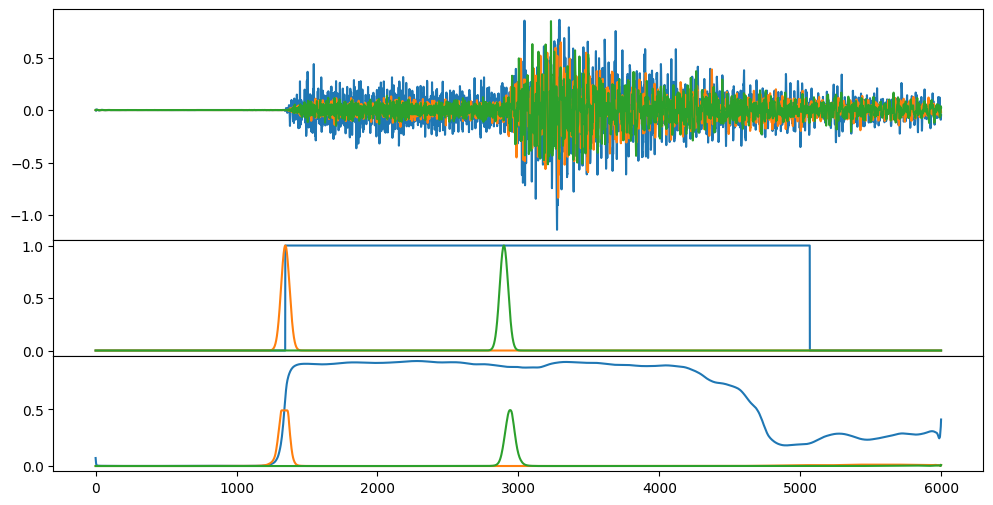

In [ ]:
solver.save_plot()

In [23]:
y_true = solver.sample['y'][0]
y_pred = solver.sample['y_pred'][0]
thres = 0.5

tp = ((y_pred > thres) * (y_true > thres)).float()
tpfp = ((y_pred) > thres).float()
tpfn = ((y_true) > thres).float()

fig, ax = plt.subplots(3)

ax[0].plot((y_true > thres) * (y_pred > .1))
ax[1].plot(y_true > thres)
ax[2].plot(y_pred > thres)
for i in range(3):
    ax[i].set_ylim(0,1)

plt.savefig('f1_plot.png')

precision = tp.sum() / (tpfp.sum() + 1e-12)
recall = tp.sum() / (tpfn.sum() + 1e-12)

# Calculate F1 score for each sample in the batch
f1 = 2 * (precision * recall) / (precision + recall + 1e-12)
f1

tensor(0.9531)

In [ ]:
tp.sum()/tpfn.sum()

tensor(0.4496)

In [ ]:

thres = .2

In [ ]:
from thop import profile

def calculate_netscore(model, a=5, b=.5, c=.5):
  input_size = (128, 3, 6000)
  flops, params = profile(model, inputs=(torch.randn(*input_size),))

  an = 90
  pn = params
  mn = (flops*2)

  netscore = 20*np.log10((an**a)/(pn**b * mn**c))
  print(netscore)

calculate_netscore(model_eqt)
calculate_netscore(model_leq)


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register count_lstm() for <class 'torch.nn.modules.rnn.LSTM'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_upsample() for <class 'torch.nn.modules.upsampling.Upsample'>.
38.03618869577113
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register count_lstm() for <class 'torch.nn.modules.rnn.LSTM'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 